## <center> Port Elizabeth Crime Forecasting (2010-2023)
### <center> Anil Abraham 2023

#### <center> The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

#### Brief explanation of each column:
<ul>
<li>Crime - Description of crime committed</li>
<li>Crimes - Number of crimes committed per year</li>
<li>Police Station - Name of Police Station within Port Elizabeth</li>
<li>Province - Name of province</li>
<li>Crime Category - Binning of crime descriptions</li>
<li>Latitude/Longitude/Latitude, Longitude - Location</li>
<li>Year - Year crimes took place</li>
</ul>

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Kwazakele</li>
</ul>

### <u>Importing libraries</u>

In [61]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")

### <u>Loading dataset</u>

In [62]:
df = pd.read_csv('crimedata.csv', thousands=',') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

Crime
Crimes
Police Station
Province
Crime Category
Latitude
Longitude
Latitude, Longitude
Year


(346470, 9)

### <u>Data preprocessing</u>

#### Limit to PE only

In [63]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Bethelsdorp", "Motherwell"
            , "Kwazakele", "Ikamvelihle"] #Police stations existing within Port Elizabeth
df = df[df['Police Station'].isin(stations)].reset_index(drop=True) #Filtering

#### Drop 'Latitude,Longitude' and 'Province'

In [64]:
df.drop(['Latitude, Longitude', 'Province'], axis=1, inplace=True) #Drop redundant information

#### Other fixes

In [65]:
df = df[df['Police Station'] != 'Doringkloof'] #'Doringkloof' does not exist within the Eastern Cape, but within Gauteng. Remove this.

df.loc[df['Police Station'] == 'Kwazakele', 'Latitude'] = -33.87626 #Kwazekele's lat/long coords are wrong. Fix it.
df.loc[df['Police Station'] == 'Kwazakele', 'Longitude'] = 25.58308

#### Check for null values

In [66]:
print(f'Null values found\n{df.isna().sum()}') #Check for null values

Null values found
Crime             0
Crimes            0
Police Station    0
Crime Category    0
Latitude          0
Longitude         0
Year              0
dtype: int64


#### Check for duplicates

In [67]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True) #Drop all duplicates
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
0

After checking for duplicates
0


#### Convert to categorical

In [68]:
df['Crime'] = pd.Categorical(df['Crime']) #Convert categorical columns to pd.Categorical()
df['Police Station'] = pd.Categorical(df['Police Station'])
df['Crime Category'] = pd.Categorical(df['Crime Category'])

#### What are the datatypes used?

In [69]:
df.dtypes

Crime             category
Crimes               int64
Police Station    category
Crime Category    category
Latitude           float64
Longitude          float64
Year                 int64
dtype: object

#### High-level stats of the Boston dataframe

In [70]:
df.describe()

,Crimes,Latitude,Longitude,Year
count,5070.000000,5070.000000,5070.000000,5070.000000
mean,124.508876,-33.891864,25.570219,2016.000000
std,191.474326,0.058255,0.037196,3.742026
min,0.000000,-33.978868,25.498567,2010.000000
25%,7.000000,-33.939980,25.550250,2013.000000
50%,44.000000,-33.899428,25.583080,2016.000000
75%,159.750000,-33.851301,25.594730,2019.000000
max,1734.000000,-33.796568,25.625900,2022.000000


#### Let's take a look at the first 3 and last 3 rows of the dataset

In [71]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
0,Murder,20,Algoapark,Contact Crimes,-33.903171,25.570496,2010
1,Attempted murder,14,Algoapark,Contact Crimes,-33.903171,25.570496,2010
2,Assault with the intent to inflict grievous bo...,158,Algoapark,Contact Crimes,-33.903171,25.570496,2010
5069,Sexual Offences detected as a result of police...,1,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022
5068,Driving under the influence of alcohol or drugs,34,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022
5067,Drug-related crime,106,Walmer,Crime detected as a result of Police Action,-33.978868,25.585376,2022


#### Types of crimes grouped by crime category

In [72]:
for i, g in df.groupby(['Crime Category'])['Crime'].unique().items():
    print(f'\n***{i}***') #List all crimes grouped by their UCR_PART
    for x in g:
        print(x)


***Aggravated Robbery***
Carjacking
Robbery at residential premises
Robbery at non-residential premises
Robbery of cash in transit
Bank robbery
Truck hijacking 
Truck hijacking

***Contact Crimes***
Murder
Attempted murder
Assault with the intent to inflict grievous bodily harm
Common assault
Common robbery
Robbery with aggravating circumstances

***Contact-Related Crimes***
Arson
Malicious damage to property

***Crime detected as a result of Police Action***
Illegal possession of firearms and ammunition
Drug-related crime
Driving under the influence of alcohol or drugs
Sexual Offences detected as a result of police action

***Other Serious Crimes***
All theft not mentioned elsewhere
Commercial crime
Shoplifting

***Property-Related Crimes***
Burglary at non-residential premises
Burglary at residential premises
Theft of motor vehicle and motorcycle
Theft out of or from motor vehicle
Stock-theft

***Sexual Offences***
Rape
Sexual Assault
Attempted Sexual Offences
Contact Sexual Offence

### <u>Exploratory Data Analysis</u>

#### Interactive heatmap of crimes in Port Elizabeth

In [ ]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
heatmap = df.copy()
heatmap["Latitude"] = to_bin(df["Latitude"])
heatmap["Longitude"] = to_bin(df['Longitude'])
heatmap = heatmap.groupby(["Latitude", "Longitude", "Block"]).count()['ID'].reset_index(name='Count') #The binning prevents too many clusters of hotspots everywhere. We then count all the crimes per 0.01 lat/longitude radius.

heatmap = heatmap[(heatmap["Latitude"] != 41.800000000000004) & (heatmap["Longitude"] != -87.78)] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

def first_occurrence(series):
    return series.iloc[0] #Return only the first occurence of the lat/long pair so we can sum the count

heatmap = heatmap.sort_values("Count", ascending=False).groupby('Block')\
    .agg({'Latitude': first_occurrence, 'Longitude': first_occurrence, 'Count': 'sum'}).reset_index().sort_values("Count", ascending=False) #The same street occurs for various lat/long coord pairs, therefore we sum them up to get one result.

heatmap = heatmap[heatmap['Count'] > 3000] #Limit to areas with high crime counts


In [15]:
fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=11, height=700, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Static heatmap of Chicago crime hotspots

##### Create geodataframe

In [73]:
sum_crimes = df.groupby(['Police Station'], observed=True)['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = df['Latitude'].unique()
sum_crimes['Longitude'] = df['Longitude'].unique()
sum_crimes['size'] = sum_crimes['Crimes'] / 60
    
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(sum_crimes, crs = {'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(sum_crimes['Longitude'], sum_crimes['Latitude'])])

c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


##### Plot

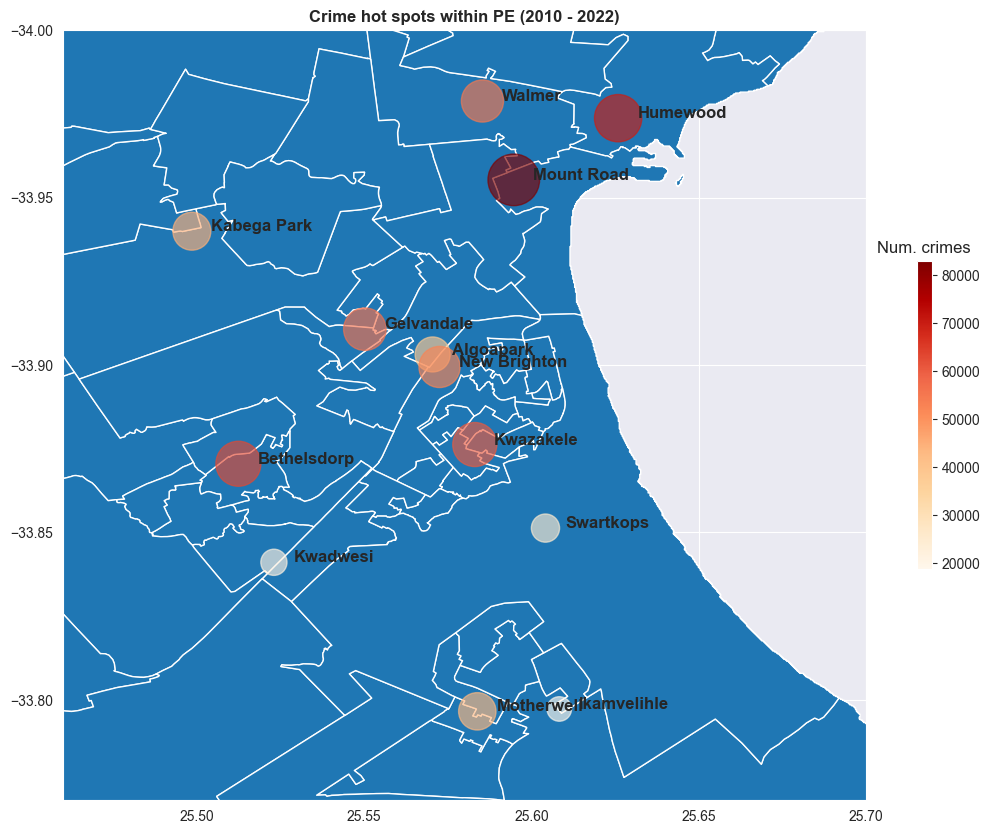

In [77]:
fig, ax = plt.subplots(figsize=(13,10))
map = gpd.read_file("SAshape/gadm41_ZAF_4.shp")
map.plot(ax=ax, aspect=1) #Plot the map of South Africa
geo_df.plot(aspect=1, column='Crimes', ax=ax, markersize='size', cmap='OrRd', legend=True, alpha=0.65, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same SA map.
ax.set_ylim([-33.77, -34])
ax.set_xlim([25.46, 25.7])
plt.title('Crime hot spots within PE (2010 - 2022)', weight='bold')
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(14,0), textcoords="offset points", weight='bold', fontsize=12)
ax.get_figure().get_axes()[1].set_title("Num. crimes")
plt.show()

In [199]:
df_grouped = df.groupby(['Police Station'], observed=True)['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'], observed=True)['Crimes'].sum()
df_grouped_y = df.groupby(['Year'], observed=True)['Crimes'].sum()

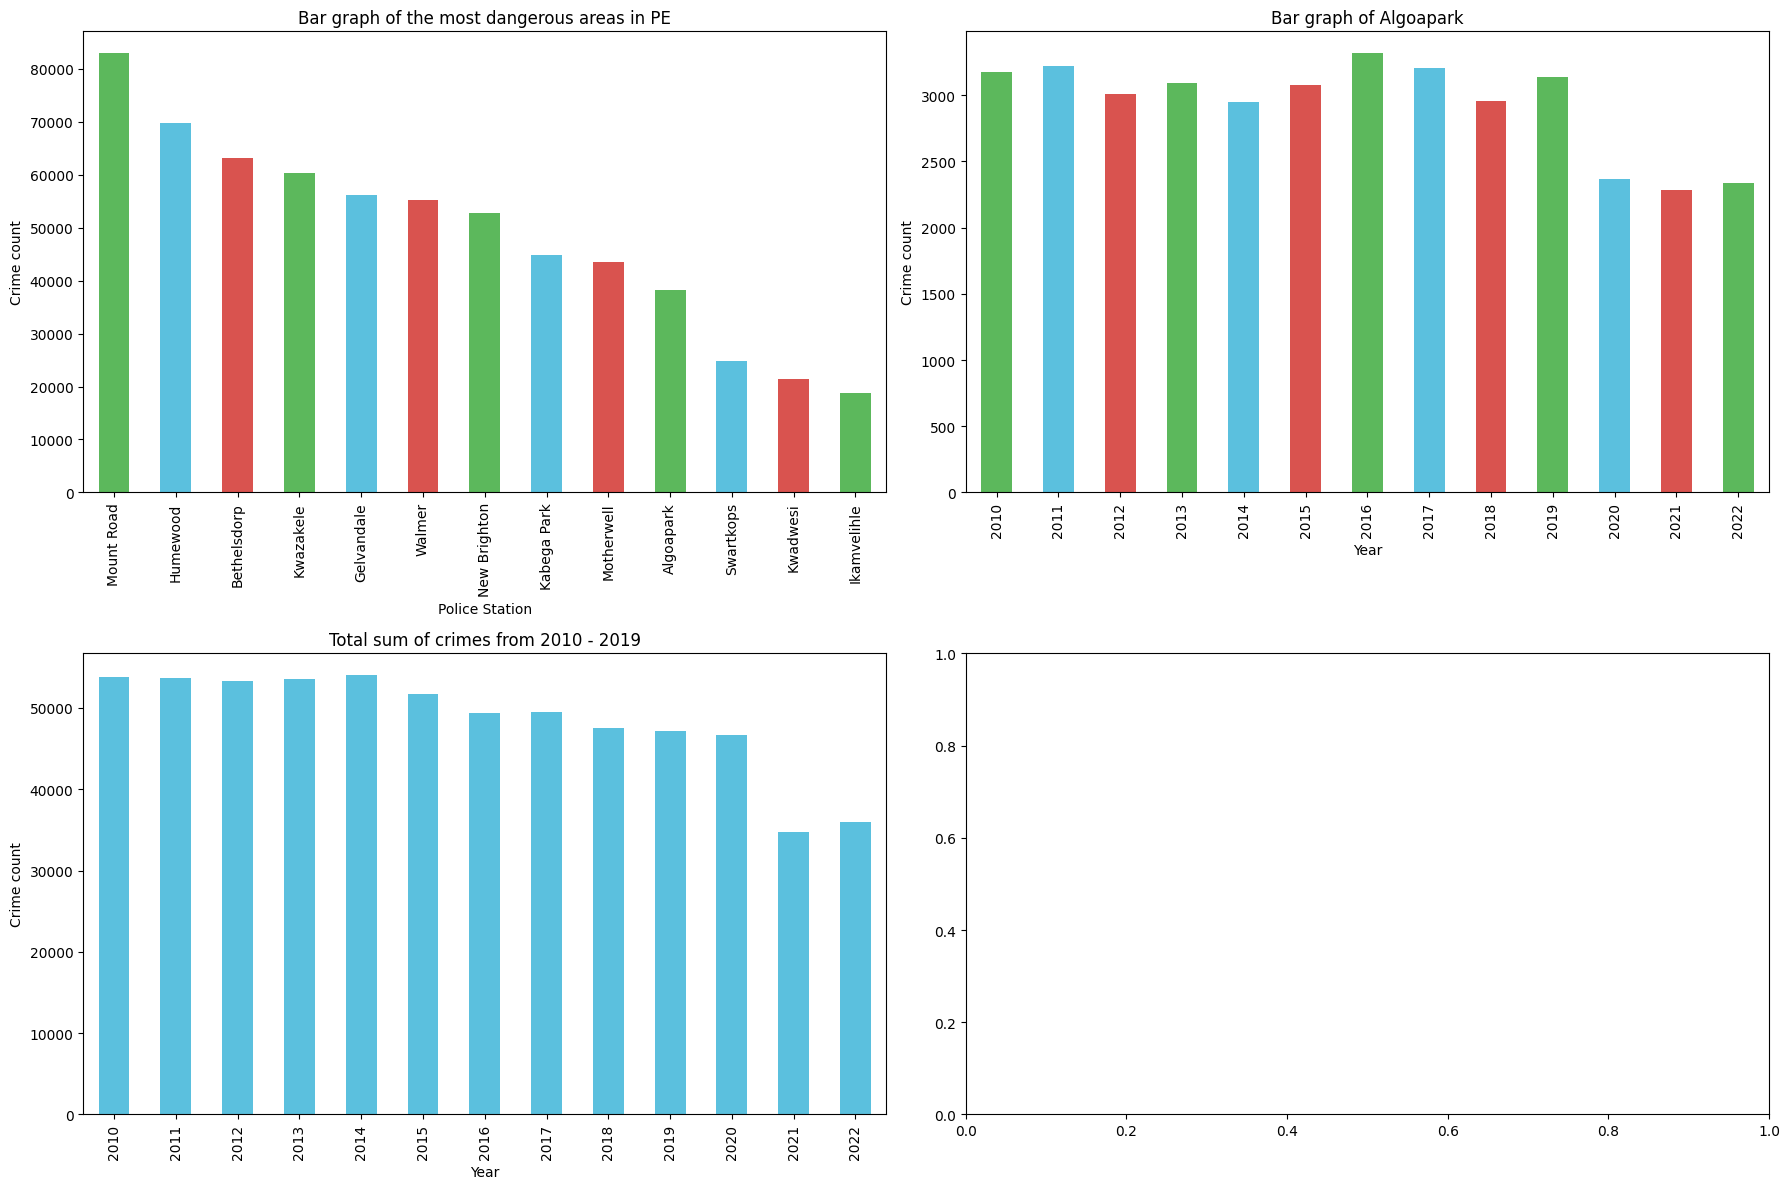

In [200]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])
df_grouped_y.plot.bar(color=['#5bc0de'], ax=axs[1,0])
#sns.barplot(df_grouped, ax=axs[0,0], x='Police Station', y='Crimes')

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('Police Station')
axs[0,0].set_ylabel('Crime count')

axs[0,1].set_title('Bar graph of Algoapark')
axs[0,1].set_xlabel('Year')
axs[0,1].set_ylabel('Crime count')

axs[1,0].set_title('Total sum of crimes from 2010 - 2019')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Crime count')

plt.tight_layout()

In [201]:
df_grouped = df_grouped.reset_index()
df_grouped

,Police Station,Crimes
0,Algoapark,38140
1,Bethelsdorp,63089
2,Gelvandale,56207
3,Humewood,69647
4,Ikamvelihle,18720
5,Kabega Park,44750
6,Kwadwesi,21329
7,Kwazakele,60383
8,Motherwell,43477
9,Mount Road,82896


In [203]:
# fig = px.treemap(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
# fig.show()

df.groupby(['Crime Category'], observed=True)['Crimes'].sum().sort_values(ascending=False)

Crime Category
Contact Crimes                                 178913
Property-Related Crimes                        157408
Other Serious Crimes                           135058
Crime detected as a result of Police Action     74759
Contact-Related Crimes                          46726
Aggravated Robbery                              21172
Sexual Offences                                 17224
Name: Crimes, dtype: int64

#### There are 30 unique classes of crimes with 7 unique crime categories

In [204]:
df[(df['Police Station'] == 'Algoapark') & (df['Year'] == 2019)]

,Crime,Crimes,Police Station,Crime Category,Latitude,Longitude,Year
3510,Murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3511,Attempted murder,23,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3512,Assault with the intent to inflict grievous bo...,137,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3513,Common assault,223,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3514,Common robbery,81,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3515,Robbery with aggravating circumstances,262,Algoapark,Contact Crimes,-33.903171,25.570496,2019
3516,Rape,52,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3517,Sexual Assault,12,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3518,Attempted Sexual Offences,0,Algoapark,Sexual Offences,-33.903171,25.570496,2019
3519,Contact Sexual Offences,7,Algoapark,Sexual Offences,-33.903171,25.570496,2019


### <u>Machine Learning</u>

#### Import

In [314]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier

#### Experiment 1: Predict 2020-2023 crime rates for various crimes across Port Elizabeth

#### Data aquisition and categorical encoding

In [325]:
X = df.drop(['Crimes'], axis=1)
y = df.iloc[:, 1]

# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
# X = ct.fit_transform(X)

encoder = TargetEncoder(cols=['Crime', 'Police Station', 'Crime Category'], smoothing=10).fit(X, y)
X = encoder.transform(X)
# le_name_mapping = dict(zip(encoder.classes_, le.transform(le.classes_)))
encoder_mapping = pd.concat([encoder.mapping['Police Station'].reset_index()[0].iloc[:13], pd.Series(stations)], axis=1)

#### Sampling/split

In [326]:
# mask = X['Year'] < 2020

# X_train = X[mask]
# X_test = X[~mask]

# y_train = y[mask]
# y_test = y[~mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [334]:
def modelEvaluation(clf, encoder, scoring):
    cv = KFold(n_splits=5)
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"])
    for i in range(len(clf)):  
        start = process_time()  
        name = clf[i].__class__.__name__
        model = make_pipeline(encoder[i], StandardScaler(), clf[i]) if name == 'KNeighborsClassifier' else make_pipeline(encoder[i], clf[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        avg = round(cv_score.mean()*100, 2)
        std = round(cv_score.std()*100,2)
        accuracy = round(accuracy_score(y_test, y_pred)*100,2)
        precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
        recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
        f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
        print(f"{name} {avg}% std: {std} test: {accuracy}")
        print(f"{name} accuracy score: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
        end = process_time()
        print(f"Time taken: {end-start}s\n")
        results = pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})])

    return results.reset_index(drop=True)
  
clf = [RandomForestClassifier(n_jobs=-1, random_state=42),
       DecisionTreeClassifier(random_state=42), 
       CatBoostClassifier(random_state=42, silent=True, allow_writing_files=False),
       AdaBoostClassifier(random_state=42),
       GaussianNB()
       #KNeighborsClassifier()
       ]
encoders = [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            #OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ]

RandomForestRegressor()

#### Cross Validation & Results

In [335]:
d = modelEvaluation(clf, encoders, 'f1_weighted')

1595.790774227482


0.9585336529378067

In [ ]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

## <center><b>Thanks for reading!</b>